In [24]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import pandas as pd
from scipy import signal
import warnings
from IPython.display import display
from matplotlib import rcParams

rcParams.update({"figure.autolayout": True})
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = True

warnings.filterwarnings("ignore")

# Clear any previous plots
plt.close("all")

# Define the Laplace variable using control library
# This is your system's open loop transfer function. Replace as per your system design.
G = ctrl.tf([1], [2, 1])  # G = 1/(2*s+1)

# Design the K to satisfy the steady state error requirements and add integrator
# to ensure zero steady state error. Reduce the gain if compensator is not able
# to achieve the desired phase margin. In some cases a compensator may not be
# sufficient to achieve the desired phase margin, in that case both lead and lag
# compensator will be required.
K = 100
# Add integrator (1/s) to the system
integrator = ctrl.tf([1], [1, 0])  # 1/s
G = K * G * integrator


print("System transfer function with gain and integrator:")
print(G)

System transfer function with gain and integrator:
<TransferFunction>: sys[141]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     100
  ---------
  2 s^2 + s


Gain Margin: inf dB at Frequency: nan rad/s
Phase Margin: 4.05 degrees at Frequency: 7.06 rad/s


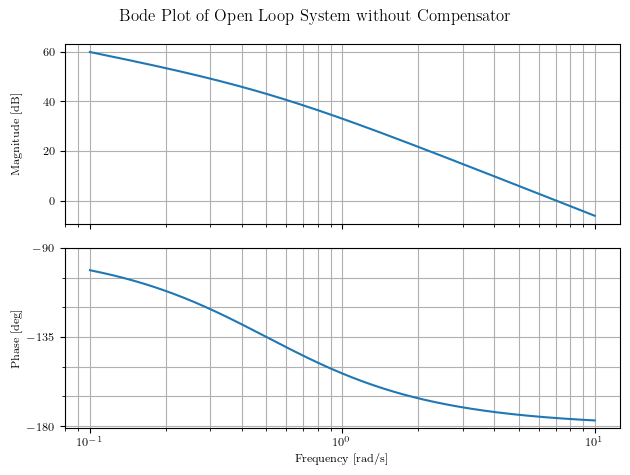

In [25]:
# Find system margins without compensator
gm, pm, wg, wp = ctrl.margin(G)

# Display the gain and phase margins
print(f"Gain Margin: {20*np.log10(gm):.2f} dB at Frequency: {wg:.2f} rad/s")
print(f"Phase Margin: {pm:.2f} degrees at Frequency: {wp:.2f} rad/s")

# Plot Bode plot to visualize margins
plt.figure()
ctrl.bode(G, dB=True, plot=True)
plt.suptitle("Bode Plot of Open Loop System without Compensator")
plt.show()

In [26]:
# Initialize arrays for storing results
phi_d_values = [30, 40, 45, 50, 60]
phi_di = []
phi_m = []
alpha = []
tau = []
gm_comp = []
pm_comp = []
compensators = []

# Store uncompensated phase margin
PM_uncompensated = pm

print(f"Original Phase Margin: {PM_uncompensated:.2f} degrees\n")
print("Designing lead compensators for different desired phase margins:")
print("=" * 60)

Original Phase Margin: 4.05 degrees

Designing lead compensators for different desired phase margins:


In [27]:
# Design lead compensators for different desired phase margins
for i, phi_d in enumerate(phi_d_values):
    print(f"\nDesigning for desired PM = {phi_d}°:")

    # Calculate required additional phase margin (with 5° safety factor)
    phi_m_required = phi_d - PM_uncompensated + 5
    phi_m.append(phi_m_required)
    phi_di.append(phi_d)

    # Calculate alpha (lead compensator parameter)
    alpha_val = (1 - np.sin(np.radians(phi_m_required))) / (
        1 + np.sin(np.radians(phi_m_required))
    )
    alpha.append(alpha_val)

    # Automatic calculation of compensator frequency
    alpha_attenuation_db = 10 * np.log10(alpha_val)

    # Get frequency response of the uncompensated system
    w = np.logspace(-2, 3, 1000)
    mag, phase, omega = ctrl.bode_plot(G, w, plot=False)
    mag_db = 20 * np.log10(mag)

    # Find frequency where magnitude equals alpha attenuation
    index = np.argmin(np.abs(mag_db - alpha_attenuation_db))
    omega_max = omega[index]

    # Calculate the compensator time constant
    tau_val = 1 / (omega_max * np.sqrt(alpha_val))
    tau.append(tau_val)

    # Create the lead compensator: C(s) = (1 + tau*s) / (1 + alpha*tau*s)
    C = ctrl.tf([tau_val, 1], [alpha_val * tau_val, 1])
    compensators.append(C)

    # Calculate margins of compensated system
    gm_c, pm_c, wg_c, wp_c = ctrl.margin(G * C)
    gm_comp.append(gm_c)
    pm_comp.append(pm_c)

    print(f"  Required additional PM: {phi_m_required:.2f}°")
    print(f"  Alpha: {alpha_val:.4f}")
    print(f"  Tau: {tau_val:.4f}")
    print(f"  Omega_max: {omega_max:.2f} rad/s")
    print(f"  Compensated PM: {pm_c:.2f}°")
    print(f"  Compensated GM: {20*np.log10(gm_c):.2f} dB")


Designing for desired PM = 30°:
  Required additional PM: 30.95°
  Alpha: 0.3207
  Tau: 0.1879
  Omega_max: 9.40 rad/s
  Compensated PM: 34.00°
  Compensated GM: inf dB

Designing for desired PM = 40°:
  Required additional PM: 40.95°
  Alpha: 0.2082
  Tau: 0.2103
  Omega_max: 10.42 rad/s
  Compensated PM: 43.68°
  Compensated GM: inf dB

Designing for desired PM = 45°:
  Required additional PM: 45.95°
  Alpha: 0.1636
  Tau: 0.2213
  Omega_max: 11.17 rad/s
  Compensated PM: 48.53°
  Compensated GM: inf dB

Designing for desired PM = 50°:
  Required additional PM: 50.95°
  Alpha: 0.1257
  Tau: 0.2383
  Omega_max: 11.83 rad/s
  Compensated PM: 53.36°
  Compensated GM: inf dB

Designing for desired PM = 60°:
  Required additional PM: 60.95°
  Alpha: 0.0671
  Tau: 0.2776
  Omega_max: 13.90 rad/s
  Compensated PM: 63.01°
  Compensated GM: inf dB


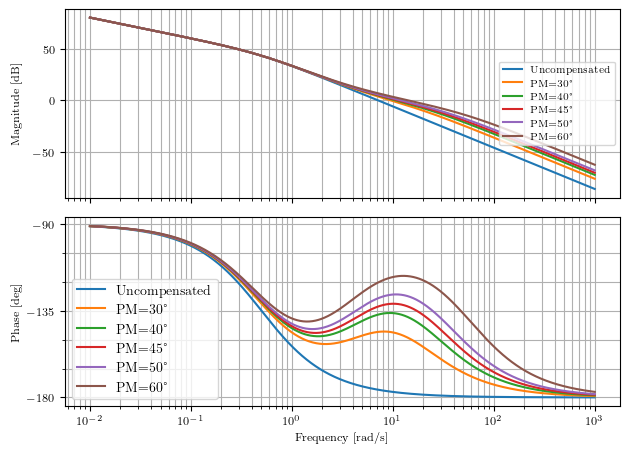

In [ ]:
# Plot Bode plots for all compensated systems
# Plot uncompensated system
w = np.logspace(-2, 3, 1000)
ctrl.bode_plot(G, w, dB=True, deg=True, label="Uncompensated", plot=True)

# Plot compensated systems
for i, (phi_d, C) in enumerate(zip(phi_d_values, compensators)):
    ctrl.bode_plot(G * C, w, dB=True, deg=True, label=f"PM={phi_d}°", plot=True)

plt.suptitle("Bode Plots - Compensated Systems Comparison")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

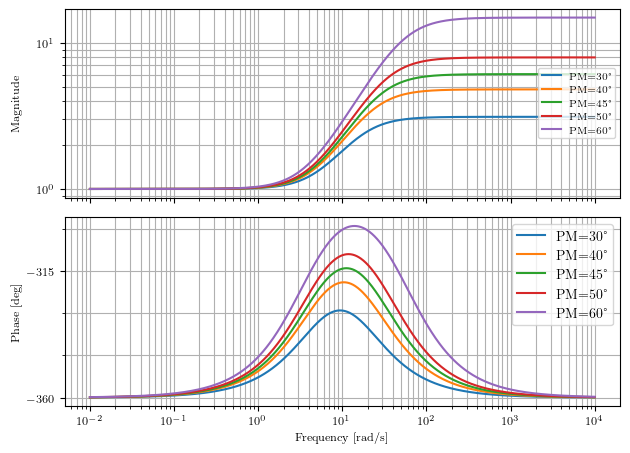

In [35]:
# Plot frequency response of the designed compensators
plt.figure()
w = np.logspace(-2, 4, 1000)
for i, (phi_d, C) in enumerate(zip(phi_d_values, compensators)):
    ctrl.bode_plot(C, w, label=f"PM={phi_d}°")

plt.legend()
plt.grid(True)
plt.show()

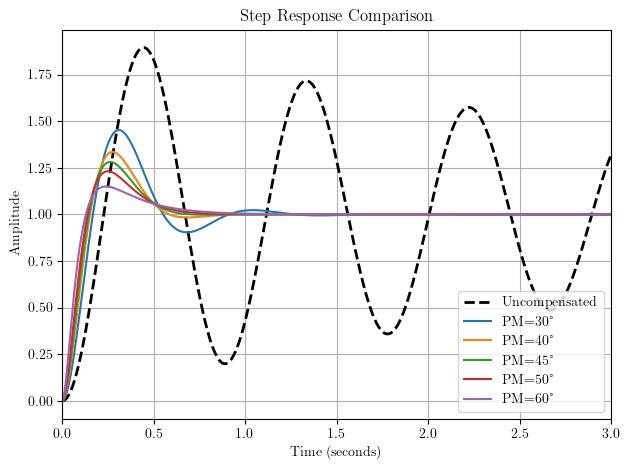

In [30]:
# Step response comparison
plt.figure()

# Time vector for step response
t = np.linspace(0, 3, 1000)

# Plot uncompensated system step response
uncompensated_cl = ctrl.feedback(G, 1)
t_uncomp, y_uncomp = ctrl.step_response(uncompensated_cl, t)
plt.plot(t_uncomp, y_uncomp, "k--", linewidth=2, label="Uncompensated")

# Plot compensated systems step responses
for i, (phi_d, C) in enumerate(zip(phi_d_values, compensators)):
    compensated_cl = ctrl.feedback(G * C, 1)
    t_comp, y_comp = ctrl.step_response(compensated_cl, t)
    plt.plot(t_comp, y_comp, label=f"PM={phi_d}°")

plt.title("Step Response Comparison")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.xlim(0, 3)
plt.show()

In [31]:
# Create summary table
PM_uncompensated_array = [PM_uncompensated] * len(phi_d_values)
gm_comp_db = [20 * np.log10(gm) for gm in gm_comp]

# Create DataFrame for results summary
results_df = pd.DataFrame(
    {
        "PM (Desired)": phi_di,
        "PM (Uncompensated)": PM_uncompensated_array,
        "PM (Compensated)": pm_comp,
        "GM (Compensated) [dB]": gm_comp_db,
        "Alpha": alpha,
        "Tau": tau,
    }
)

print("\nSummary Table:")
print("=" * 80)
display(results_df.round(4))

print(f"\nOriginal Phase Margin: {PM_uncompensated:.2f}°")


Summary Table:


,PM (Desired),PM (Uncompensated),PM (Compensated),GM (Compensated) [dB],Alpha,Tau
0,30,4.0497,33.9993,inf,0.3207,0.1879
1,40,4.0497,43.6809,inf,0.2082,0.2103
2,45,4.0497,48.5332,inf,0.1636,0.2213
3,50,4.0497,53.3574,inf,0.1257,0.2383
4,60,4.0497,63.0141,inf,0.0671,0.2776



Original Phase Margin: 4.05°


In [32]:
# Additional analysis: Display individual compensator transfer functions
print("\nCompensator Transfer Functions:")
print("=" * 50)
for i, (phi_d, C) in enumerate(zip(phi_d_values, compensators)):
    print(f"\nFor PM = {phi_d}°:")
    print(f"C{i+1}(s) = {C}")
    print(f"Alpha = {alpha[i]:.4f}, Tau = {tau[i]:.4f}")

print("\nNote:")
print("- Lead compensators improve transient response and phase margin")
print("- Higher desired phase margins result in larger alpha values")
print("- The compensator adds phase lead at the gain crossover frequency")
print("- If a single lead compensator cannot achieve the desired PM,")
print("  consider using both lead and lag compensators (lead-lag design)")


Compensator Transfer Functions:

For PM = 30°:
C1(s) = <TransferFunction>: sys[144]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.1879 s + 1
  -------------
  0.06027 s + 1
Alpha = 0.3207, Tau = 0.1879

For PM = 40°:
C2(s) = <TransferFunction>: sys[147]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.2103 s + 1
  -------------
  0.04377 s + 1
Alpha = 0.2082, Tau = 0.2103

For PM = 45°:
C3(s) = <TransferFunction>: sys[150]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.2213 s + 1
  -------------
  0.03622 s + 1
Alpha = 0.1636, Tau = 0.2213

For PM = 50°:
C4(s) = <TransferFunction>: sys[153]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.2383 s + 1
  -------------
  0.02997 s + 1
Alpha = 0.1257, Tau = 0.2383

For PM = 60°:
C5(s) = <TransferFunction>: sys[156]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.2776 s + 1
  -------------
  0.01863 s + 1
Alpha = 0.0671, Tau = 0.2776

Note:
- Lead compensators improve transient response and phase margin
- Higher desired phase margins resul